In [1]:
import subprocess
import numpy as np
from scipy import optimize 
import matplotlib.pyplot as plt

%matplotlib inline

Создадим шаблон, где будем заменять значения длин и углов связей.

In [2]:
input_file = '''!HF RHF 6-31G
* int 0 1
C 0 0 0 0 0 0 
C 1 0 0 {CC} 0 0 
H 1 2 0 1.08439 {HCC} 0
H 1 2 3 1.08439 {HCC} 120
H 1 2 3 1.08439 {HCC} -120
H 2 1 3 1.08439 {HCC} {HCCH1}
H 2 1 5 1.08439 {HCC} {HCCH2}
H 2 1 5 1.08439 {HCC} {HCCH3}
*
'''

Зададим функции для подсчёта энергии, для запуска ORCA и для отрисовки графика квадратичной (?) функции.

In [3]:
def energy_counter(i_file, variable, start, step, num):
    value = start
    energy = []
    value_set = []
    
    if (variable == "CC"):
        for i in range(num):
            value = start + i*step
            inp = i_file.format(CC = str(value), 
                                HCC = str(111.200), 
                                HCCH1 = str(180), 
                                HCCH2 = str(120), 
                                HCCH3 = str(-120))
            energy.append(run_orca(inp))
            value_set.append(value)
            
    elif (variable == "HCС"):
        for i in range(num):
            value = start + i*step
            inp = i_file.format(CC = str(1.52986),
                                HCC = str(value),
                                HCCH1 = str(180), 
                                HCCH2 = str(120), 
                                HCCH3 = str(-120))
            energy.append(run_orca(inp))
            value_set.append(value)
            
    elif (variable == "HCCH"):
        for i in range(num):
            value = start + i*step
            inp = i_file.format(CC = str(1.52986), 
                                HCC = str(111.200),
                                HCCH1 = str(value),
                                HCCH2 = str(value-60),
                                HCCH3 = str(value+60), 
                                )
            energy.append(run_orca(inp))
            value_set.append(value)

    return value_set, energy

In [4]:
def run_orca(inp):
    with open('orca.inp', 'w') as outfile:
        outfile.write(inp)
    p = subprocess.Popen("/home/shad/progs/bin/orca orca.inp", 
                          shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out = p.communicate()[0]

    for line in out.splitlines():
        if "FINAL SINGLE POINT ENERGY" in line:
            return float(line.split('FINAL SINGLE POINT ENERGY')[-1].strip())

In [5]:
def plot(x_o, y_o):
    
    #function is f(x) = k(b-x)^2 + a
    fitfunc = lambda p, x: p[0] * pow(p[1] - x, 2) + p[2]
    errfunc = lambda p, x, y: fitfunc(p, x) - y

    p0 = [1, 1, -79]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
    print("Optimized params:", p1)

    plt.plot(x_o, y_o, "ro", x_o, fitfunc(p1, x_o), "r-", c='hotpink', alpha=0.5)
    plt.show()

Рассчитаем энергию для 20 разных длинн связи (C-C) с шагом 0.02 ангстрема. Чтобы центр был в минимуме, отступим на 0.2 ангстрема в обе стороны от него.

('Optimized params:', array([  0.66824628,   1.55389274, -79.08233322]))


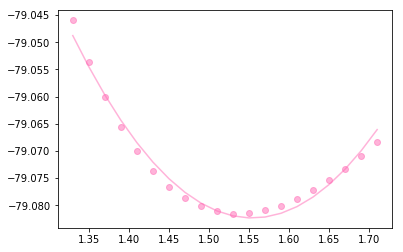

In [6]:
x_CC_02, y_CC_02 = energy_counter(input_file, variable="CC", start=1.32986, step=0.02, num=20)
plot(x_CC_02, y_CC_02)

Функция почти подходит.

Теперь повторим аналогичные действия для валентного угла HCС. Начинаем со значения угла 109.2 и с шагом 0.02 ангстрема изменяем до 113.2.

('Optimized params:', array([ 3.30816512e-04,  1.12271983e+02, -7.90819114e+01]))


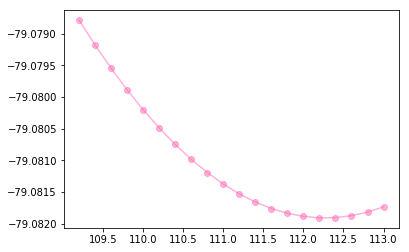

In [7]:
x_HCC, y_HCC = energy_counter(input_file, variable="HCС", start=109.2, step=0.2, num=20)
plot(x_HCC, y_HCC)

Хорошо подходит!

Теперь будем считать энергию для разных торсионных углов CC. Эти значения должны изменяться от -180 до 180 c шагом 12.

('Optimized params:', array([ 1.34231799e-08, -8.70264360e+01, -7.90827628e+01]))


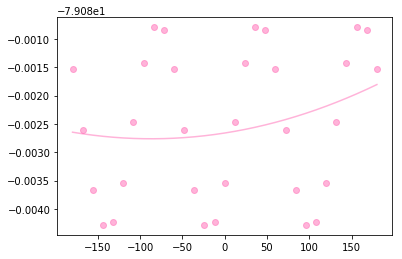

In [8]:
x_HCCH, y_HCCH = energy_counter(input_file, variable="HCCH", start=-180, step=12, num=31)
plot(x_HCCH, y_HCCH)

Вообще не подходит. Попробуем сделать зависимость от синуса и косинуса.

('Optimized params:', array([-1.50760465e-03,  9.94841115e-01, -1.00591816e-03,  9.94840464e-01,
       -7.90825389e+01]))


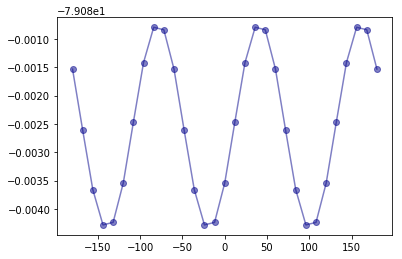

In [9]:
def plot_sin_cos(x_o, y_o):
    x_o = np.array(x_o)    
    y_o = np.array(y_o)
    
    #f(x) = a*sin(b*x) + c*cos(d*x)
    fitfunc = lambda p, x: p[0] * np.sin(p[1] * x) + p[2] * np.cos(p[3] * x) + p[4]
    errfunc = lambda p, x, y: fitfunc(p, x) - y

    p0 = [1, 1, 1, 1, -79]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
    print("Optimized params:", p1)

    plt.plot(x_o, y_o, "ro", x_o, fitfunc(p1, x_o),"r-", c='darkblue', alpha=0.5)
    plt.show()

plot_sin_cos(x_HCCH, y_HCCH)

Хорошо подходит! 

Минимумов три.

Увеличим шаг для расчета связей (C-C) до 0.1 ангстрема. Для наглядности начало будет на 1Å меньше оптимума, а конец продлён примерно до 4Å.

('Optimized params:', array([  0.72312713,   2.57816881, -79.38467002]))


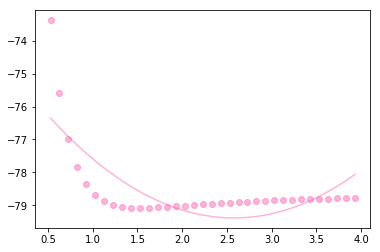

In [13]:
x_CC_01, y_CC_01 = energy_counter(input_file, variable="CC", start=0.52986, step=0.1, num=35)
plot(x_CC_01, y_CC_01)

Первая функция не подходит. Для аппроксимации предлагаю использовать потенциал Морзе, поскольку он используется как приближение для энергии двухатомной молекулы, а мы считаем энергию по сути как раз для такого случая, если в этане не учитывать атомы водорода.

$$\begin{equation*}
     V(r)=D_{e}(1-e^{-a(r-r_{e})})^2
\end{equation*}$$

('Optimized params:', array([  0.26809855,   1.88808438,   1.44217464, -79.09303274]))


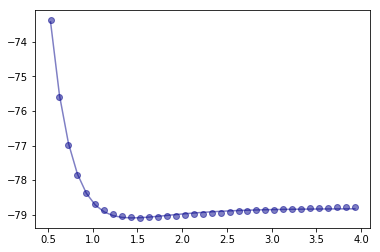

In [14]:
def plot_morse(x_o, y_o):
    x_o = np.array(x_o)
    
    #function Morse
    fitfunc = lambda p, x: p[0] * pow(1 - np.exp(-p[1] * (x - p[2])), 2) + p[3]
    errfunc = lambda p, x, y: fitfunc(p, x) - y

    p0 = [1, 1, 1, -79]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
    print("Optimized params:", p1)
    
    plt.plot(x_o, y_o, "ro", x_o,fitfunc(p1, x_o), "r-", c='darkblue', alpha=0.5)
    plt.show()
    
plot_morse(x_CC_01, y_CC_01)

Красиво подошло!